In [ ]:
pip install stim

In [8]:
import stim
import numpy as np
import stim
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import math

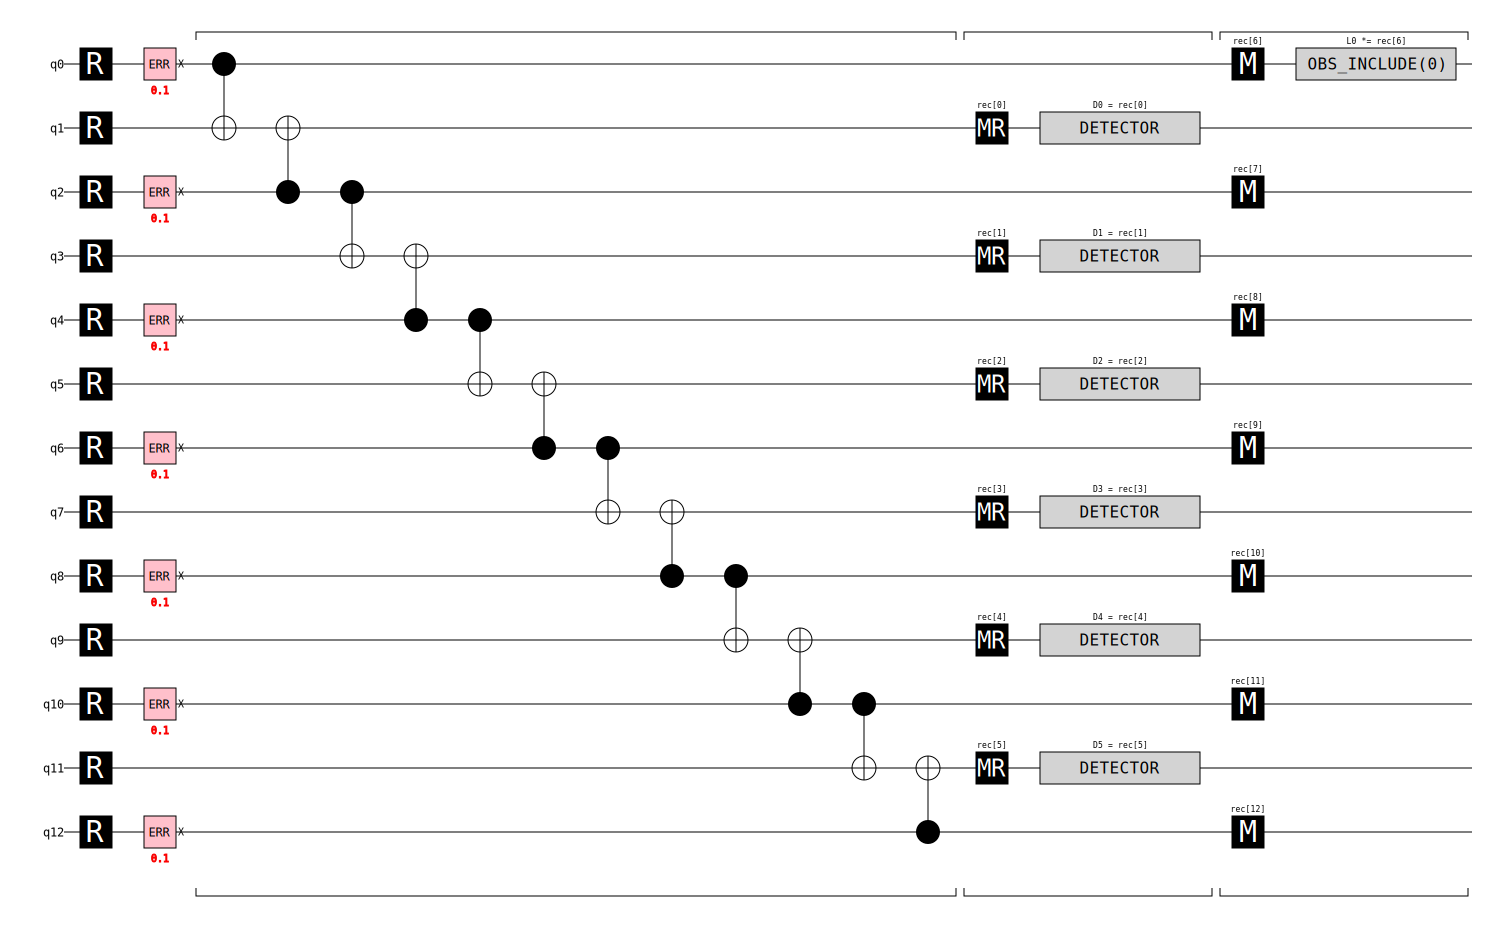

In [9]:
# REPTITION CODE

circuit = stim.Circuit('''
    R 0 2 4 6 8 10 12 1 3 5 7 9 11
TICK
X_ERROR(0.1) 0 2 4 6 8 10 12
TICK
CX 0 1 2 1 2 3 4 3 4 5 6 5 6 7 8 7 8 9 10 9 10 11 12 11
TICK
MR 1 3 5 7 9 11
DETECTOR rec[-6]
DETECTOR rec[-5]
DETECTOR rec[-4]
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
TICK
M 0 2 4 6 8 10 12
OBSERVABLE_INCLUDE(0) rec[-7]
''')

circuit.diagram('timeline-svg')

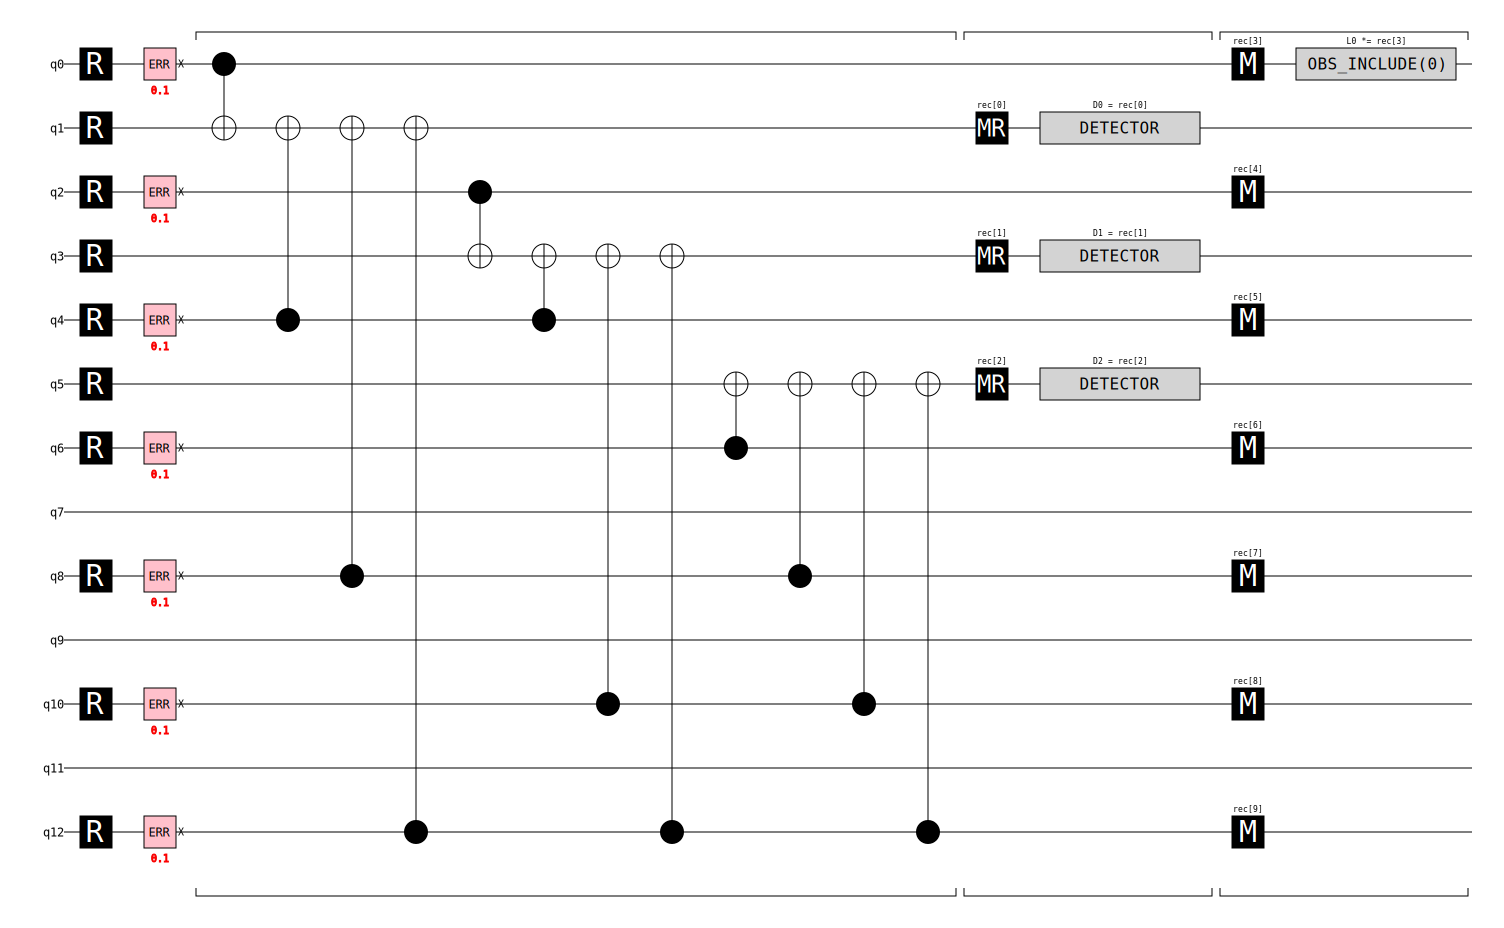

In [4]:
#CONCATENATED HAMMING

circuit = stim.Circuit('''
    R 0 2 4 6 8 10 12 1 3 5
TICK
X_ERROR(0.1) 0 2 4 6 8 10 12
TICK
CX 0 1 4 1 8 1 12 1 2 3 4 3 10 3 12 3 6 5 8 5 10 5 12 5
TICK
MR 1 3 5
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
TICK
M 0 2 4 6 8 10 12
OBSERVABLE_INCLUDE(0) rec[-7]
''')

circuit.diagram('timeline-svg')

# Repetition Code

In [13]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import math

# ============================================================================
# REPETITION CODE (Baseline)
# ============================================================================

def decode_repetition_code(meas: Tuple[str, str]) -> int:
    """Syndrome-aware decoder for the n-qubit repetition code."""
    data_bits, synd = meas
    n = len(data_bits)
    data = list(map(int, data_bits))
    synd = list(map(int, synd))
    
    corrected = data.copy()
    
    if all(s == 0 for s in synd):
        return corrected[0]
    
    i = 0
    while i < len(synd):
        if synd[i] == 1:
            start = i
            while i < len(synd) and synd[i] == 1:
                i += 1
            end = i
            
            left_size = start + 1
            right_size = n - end
            
            if right_size < left_size:
                for j in range(end, n):
                    corrected[j] ^= 1
            else:
                for j in range(start + 1):
                    corrected[j] ^= 1
        else:
            i += 1
    
    return corrected[0]


def repetition_code_circuit(n: int, p: float = 0.1) -> stim.Circuit:
    """Build an n-qubit repetition code circuit."""
    c = stim.Circuit()
    
    data_qubits = [2*i for i in range(n)]
    measure_qubits = [2*i + 1 for i in range(n-1)]
    c.append("R", data_qubits + measure_qubits)
    
    c.append("TICK")
    
    for q in data_qubits:
        c.append("X_ERROR", [q], p)
    
    c.append("TICK")
    
    for i, m in enumerate(measure_qubits):
        d1 = data_qubits[i]
        d2 = data_qubits[i+1]
        c.append("CX", [d1, m])
        c.append("CX", [d2, m])
    
    c.append("TICK")
    c.append("MR", measure_qubits)
    
    for i in range(n-1):
        c.append("DETECTOR", [stim.target_rec(-(n-1) + i)])
    
    c.append("TICK")
    c.append("M", data_qubits)
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-n)], 0)
    
    return c


def simulate_repetition(circuit: stim.Circuit, n: int, num_shots=100_000):
    """Simulate repetition code circuit."""
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots=num_shots)
    
    results = {}
    for shot in samples:
        synd_bits = ''.join(str(int(shot[i])) for i in range(n-1))
        data_bits = ''.join(str(int(shot[n-1 + i])) for i in range(n))
        key = (data_bits, synd_bits)
        results[key] = results.get(key, 0) + 1
    
    return results


def logical_error_rate_repetition(results: Dict[Tuple[str, str], int], logical_prepared: int = 0):
    """Compute logical error rate for repetition code."""
    errors = 0
    total = 0
    for (data_bits, synd_bits), count in results.items():
        decoded = decode_repetition_code((data_bits, synd_bits))
        if decoded != logical_prepared:
            errors += count
        total += count
    return errors / total


# Concatenated Hamming Code

In [14]:
# ============================================================================
# CONCATENATED HAMMING CODE
# ============================================================================

H_hamming = np.array([
    [1,0,1,0,1,0,1],
    [0,1,1,0,0,1,1],
    [0,0,0,1,1,1,1]
], dtype=int)


def concatenated_hamming_circuit(n_blocks: int, p: float = 0.1, prepare_logical_one: bool = False):
    """Concatenated Hamming code with variable number of blocks."""
    n_inner = 7
    n_data = n_blocks * n_inner
    n_stab_per_block = 3
    n_stabilizer = n_stab_per_block * n_blocks
    
    c = stim.Circuit()
    
    data_qubits = [2*i for i in range(n_data)]
    measure_qubits = [2*i + 1 for i in range(n_stabilizer)]
    
    c.append("R", data_qubits + measure_qubits)
    
    if prepare_logical_one:
        c.append("X", data_qubits)
    
    c.append("TICK")
    
    for q in data_qubits:
        c.append("X_ERROR", [q], p)
    
    c.append("TICK")
    
    measure_index = 0
    for outer_idx in range(n_blocks):
        block_start = outer_idx * n_inner
        for row in H_hamming:
            participating_qubits = [data_qubits[block_start + i] 
                                   for i, bit in enumerate(row) if bit == 1]
            anc = measure_qubits[measure_index]
            
            for q in participating_qubits:
                c.append("CX", [q, anc])
            
            measure_index += 1
    
    c.append("TICK")
    c.append("MR", measure_qubits)
    
    for i in range(n_stabilizer):
        c.append("DETECTOR", [stim.target_rec(-(n_stabilizer) + i)])
    
    c.append("TICK")
    c.append("M", data_qubits)
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-n_data)], 0)
    
    return c, n_data, n_stabilizer

def simulate_hamming(circuit: stim.Circuit, n_data: int, n_stabilizer: int, num_shots=100000):
    """Simulate concatenated Hamming circuit."""
    sampler = circuit.compile_sampler()
    shots = sampler.sample(shots=num_shots)
    results = {}
    
    for shot in shots:
        synd_bits = ''.join(str(int(shot[i])) for i in range(n_stabilizer))
        data_bits = ''.join(str(int(shot[n_stabilizer + i])) for i in range(n_data))
        key = (data_bits, synd_bits)
        results[key] = results.get(key, 0) + 1
    
    return results


def decode_concatenated_hamming(meas: Tuple[str, str], n_blocks: int) -> int:
    """Decoder: Inner Hamming correction + Outer Majority Vote."""
    data_bits, synd_bits = meas
    data = [int(b) for b in data_bits]
    synd = [int(b) for b in synd_bits]
    
    corrected_blocks = []
    
    for outer_idx in range(n_blocks):
        data_block = data[outer_idx * 7:(outer_idx + 1) * 7]
        syndrome_block = synd[outer_idx * 3:(outer_idx + 1) * 3]
        
        corrected = data_block.copy()
        if sum(syndrome_block) > 0:
            for pos in range(7):
                if H_hamming[:, pos].tolist() == syndrome_block:
                    corrected[pos] ^= 1
                    break
        
        block_value = 1 if sum(corrected) > 3 else 0
        corrected_blocks.append(block_value)
    
    return 1 if sum(corrected_blocks) > n_blocks // 2 else 0


def logical_error_rate_hamming(results: Dict[Tuple[str, str], int], n_blocks: int, logical_prepared: int = 0):
    """Compute logical error rate for concatenated Hamming."""
    errors = 0
    total = 0
    for (data_bits, synd_bits), count in results.items():
        decoded = decode_concatenated_hamming((data_bits, synd_bits), n_blocks)
        if decoded != logical_prepared:
            errors += count
        total += count
    return errors / total

## Scaling Analysis of the codes

In [21]:

def comprehensive_scaling_analysis(p=0.1, max_blocks=21, num_shots=30000):
    """
    Show how concatenated Hamming scales with increasing blocks/layers.
    
    Key insight: Each additional block adds to the effective distance
    - Distance = 3 × n_blocks (for odd n_blocks)
    - This allows exponentially better error suppression
    """
    
    
    hamming_blocks = list(range(1, max_blocks + 1, 2))  # 1, 3, 5, 7, ..., max_blocks
    hamming_qubits = [b * 7 for b in hamming_blocks]
    
    # Repetition: match the qubit counts
    repetition_qubits = [7, 21, 35, 49, 63, 77, 91, 105, 119, 133, 147]
    
    results = {
        'hamming_blocks': [],
        'hamming_qubits': [],
        'hamming_distance': [],
        'hamming_error_rate': [],
        'repetition_qubits': [],
        'repetition_distance': [],
        'repetition_error_rate': []
    }
    
    # Test Hamming Code at increasing scales
    print("\n📊 CONCATENATED HAMMING CODE")
    print("-"*80)
    print(f"{'Blocks':<8} | {'Qubits':<8} | {'Distance':<10} | {'Error Rate':<15} | {'Time (est.)'}")
    print("-"*80)
    
    for n_blocks in hamming_blocks:
        n_qubits = n_blocks * 7
        distance = 3 * n_blocks  # Effective distance
        
        # Estimate time
        if n_qubits <= 70:
            shots = num_shots
        else:
            shots = num_shots // 2  # Use fewer shots for large circuits
        
        print(f"{n_blocks:<8} | {n_qubits:<8} | {distance:<10} | ", end='', flush=True)
        
        total_errors = 0
        for logical_state in [0, 1]:
            circuit, n_data, n_stab = concatenated_hamming_circuit(
                n_blocks=n_blocks, p=p, prepare_logical_one=(logical_state == 1)
            )
            ham_results = simulate_hamming(circuit, n_data, n_stab, num_shots=shots//2)
            errors = sum(count for (data, synd), count in ham_results.items() 
                        if decode_concatenated_hamming((data, synd), n_blocks) != logical_state)
            total_errors += errors
        
        error_rate = total_errors / shots
        
        results['hamming_blocks'].append(n_blocks)
        results['hamming_qubits'].append(n_qubits)
        results['hamming_distance'].append(distance)
        results['hamming_error_rate'].append(error_rate)
        
        print(f"{error_rate:<15.8f} | {shots} shots")
    
    # Test Repetition Code at matching qubit counts
    print("\n📊 REPETITION CODE (for comparison)")
    print("-"*80)
    print(f"{'Qubits':<8} | {'Distance':<10} | {'Error Rate':<15} | {'Time (est.)'}")
    print("-"*80)

    for n in repetition_qubits:
        if n > max_blocks * 7:
            break
        
        distance = n
        
        if n <= 70:
            shots = num_shots
        else:
            shots = num_shots // 2
        
        print(f"{n:<8} | {distance:<10} | ", end='', flush=True)
        
        circuit = repetition_code_circuit(n=n, p=p)
        rep_results = simulate_repetition(circuit, n=n, num_shots=shots)
        error_rate = logical_error_rate_repetition(rep_results, logical_prepared=0)
        
        results['repetition_qubits'].append(n)
        results['repetition_distance'].append(distance)
        results['repetition_error_rate'].append(error_rate)
        
        print(f"{error_rate:<15.8f} | {shots} shots")
    
    return results

def plot_comprehensive_comparison(results, p):
    """Create comprehensive visualization showing the power of concatenation."""
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Error rate vs number of qubits (log-log)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.loglog(results['hamming_qubits'], results['hamming_error_rate'], 
              's-', linewidth=3, markersize=10, label='Concatenated Hamming', 
              color='#ff7f0e', markeredgecolor='black', markeredgewidth=0.5)
    ax1.loglog(results['repetition_qubits'], results['repetition_error_rate'], 
              'o-', linewidth=3, markersize=10, label='Repetition Code', 
              color='#1f77b4', markeredgecolor='black', markeredgewidth=0.5)
    ax1.axhline(y=p, color='red', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'Physical error rate (p={p})')
    
    ax1.set_xlabel('Number of Physical Qubits', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Logical Error Rate', fontsize=14, fontweight='bold')
    ax1.set_title(f'Error Suppression Scaling (p = {p})\nConcatenated Hamming vs Repetition Code', 
                 fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12, loc='lower left')
    ax1.grid(True, alpha=0.3, which='both')
    
    # Add annotations for key crossover points
    for i in [2, 4, 6]:
        if i < len(results['hamming_error_rate']):
            ax1.annotate(f"{results['hamming_blocks'][i]} blocks\nd={results['hamming_distance'][i]}", 
                        xy=(results['hamming_qubits'][i], results['hamming_error_rate'][i]),
                        xytext=(10, 20), textcoords='offset points',
                        fontsize=9, ha='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Plot 2: Distance vs Qubits
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(results['hamming_qubits'], results['hamming_distance'], 
            's-', linewidth=2.5, markersize=8, label='Hamming', color='#ff7f0e')
    ax2.plot(results['repetition_qubits'], results['repetition_distance'], 
            'o-', linewidth=2.5, markersize=8, label='Repetition', color='#1f77b4')
    
    ax2.set_xlabel('Number of Physical Qubits', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Code Distance', fontsize=12, fontweight='bold')
    ax2.set_title('Code Distance Growth', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Distance vs Error Rate
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.semilogy(results['hamming_distance'], results['hamming_error_rate'], 
                's-', linewidth=2.5, markersize=8, label='Hamming', color='#ff7f0e')
    ax3.semilogy(results['repetition_distance'], results['repetition_error_rate'], 
                'o-', linewidth=2.5, markersize=8, label='Repetition', color='#1f77b4')
    
    ax3.set_xlabel('Code Distance', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Logical Error Rate', fontsize=12, fontweight='bold')
    ax3.set_title('Error Rate vs Distance', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
   
    # Plot 5: Efficiency (error suppression per qubit)
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Calculate error suppression per qubit
    ham_efficiency = [np.log10(p / err) / n if err > 0 else None 
                     for err, n in zip(results['hamming_error_rate'], results['hamming_qubits'])]
    rep_efficiency = [np.log10(p / err) / n if err > 0 else None
                     for err, n in zip(results['repetition_error_rate'], results['repetition_qubits'])]
    
    valid_ham_qubits = [results['hamming_qubits'][i] for i in range(len(ham_efficiency)) 
                       if ham_efficiency[i] is not None]
    valid_ham_eff = [e for e in ham_efficiency if e is not None]
    
    valid_rep_qubits = [results['repetition_qubits'][i] for i in range(len(rep_efficiency)) 
                       if rep_efficiency[i] is not None]
    valid_rep_eff = [e for e in rep_efficiency if e is not None]
    
    ax5.plot(valid_ham_qubits, valid_ham_eff, 
            's-', linewidth=2.5, markersize=8, label='Hamming', color='#ff7f0e')
    ax5.plot(valid_rep_qubits, valid_rep_eff, 
            'o-', linewidth=2.5, markersize=8, label='Repetition', color='#1f77b4')
    
    ax5.set_xlabel('Number of Physical Qubits', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Error Suppression per Qubit\n(log₁₀(p/p_L) / n)', fontsize=12, fontweight='bold')
    ax5.set_title('Qubit Efficiency', fontsize=13, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    
    plt.savefig(f'comprehensive_scaling_analysis_p{p}.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved comprehensive plot to 'comprehensive_scaling_analysis_p{p}.png'")
    plt.show()

    


📊 CONCATENATED HAMMING CODE
--------------------------------------------------------------------------------
Blocks   | Qubits   | Distance   | Error Rate      | Time (est.)
--------------------------------------------------------------------------------
1        | 7        | 3          | 0.10523333      | 30000 shots
3        | 21       | 9          | 0.02843333      | 30000 shots
5        | 35       | 15         | 0.00953333      | 30000 shots
7        | 49       | 21         | 0.00290000      | 30000 shots
9        | 63       | 27         | 0.00113333      | 30000 shots
11       | 77       | 33         | 0.00066667      | 15000 shots
13       | 91       | 39         | 0.00020000      | 15000 shots
15       | 105      | 45         | 0.00000000      | 15000 shots
17       | 119      | 51         | 0.00000000      | 15000 shots
19       | 133      | 57         | 0.00000000      | 15000 shots
21       | 147      | 63         | 0.00000000      | 15000 shots
23       | 161      | 69     

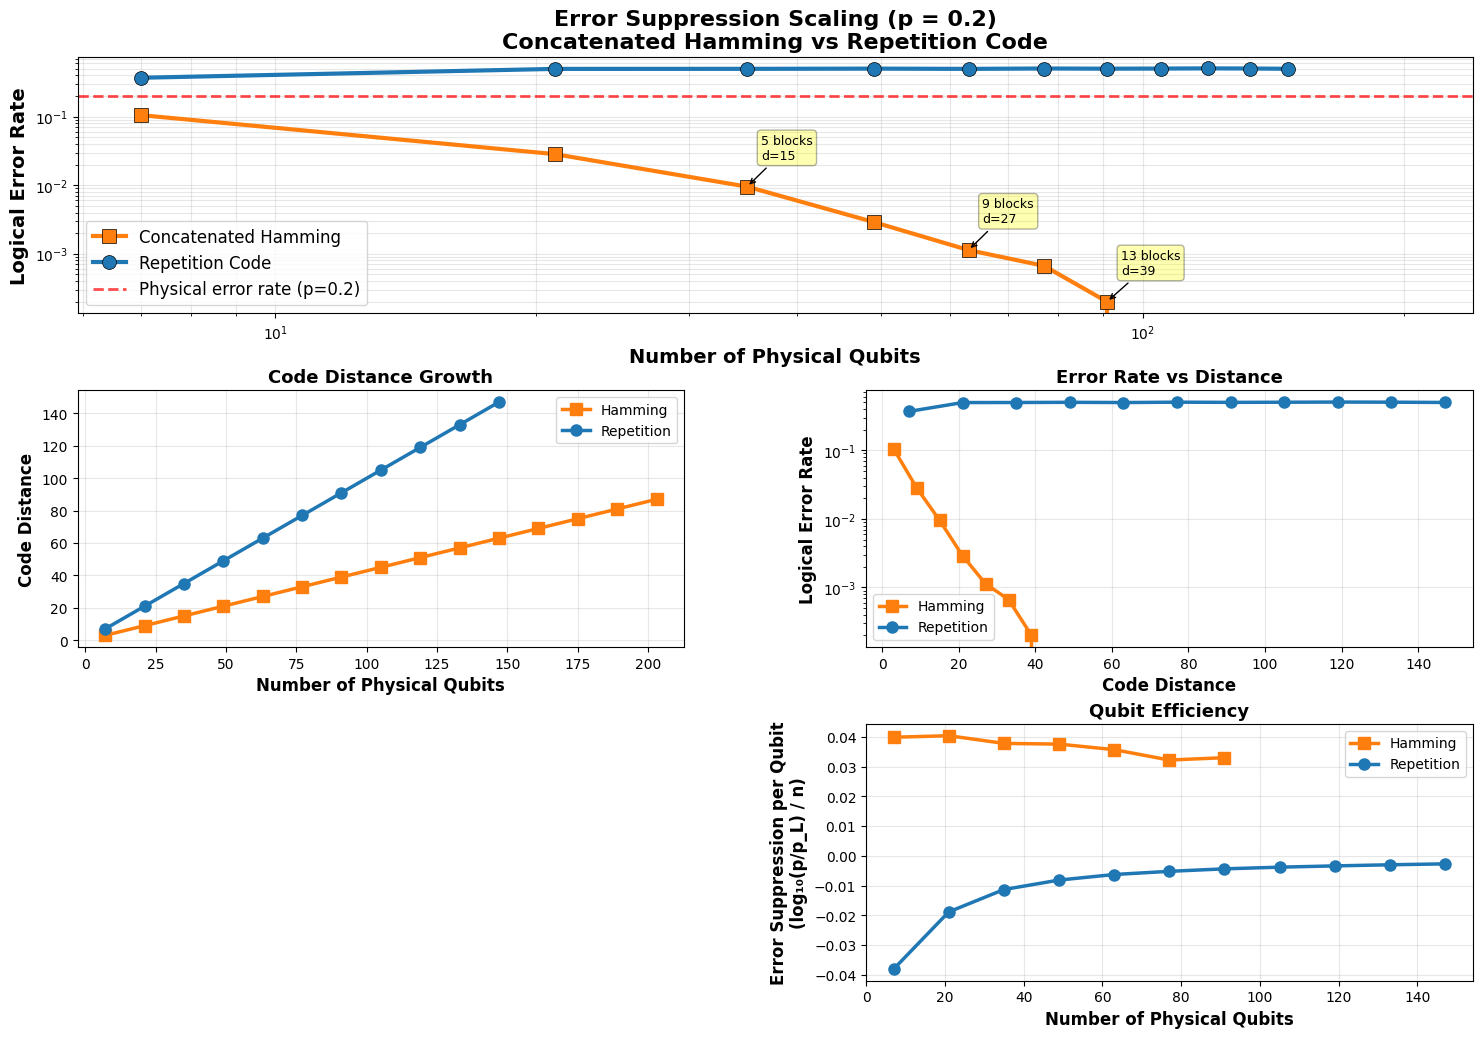

In [25]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    
    
    # Run comprehensive analysis
    p = 0.2
    max_blocks = 30  # Test up to 21 blocks (147 qubits)
    
    results = comprehensive_scaling_analysis(p=p, max_blocks=max_blocks, num_shots=30000)
    
    # Create visualizations
    plot_comprehensive_comparison(results, p)
    

In [27]:
# ============================================================================
# MULTI-LEVEL CONCATENATED HAMMING CODE (CORRECTED)
# ============================================================================

H_hamming = np.array([
    [1,0,1,0,1,0,1],
    [0,1,1,0,0,1,1],
    [0,0,0,1,1,1,1]
], dtype=int)


def calculate_concatenation_parameters(levels: int):
    """
    Calculate parameters for multi-level concatenation.
    
    Distance grows EXPONENTIALLY
    
    For Hamming(7,4) with base distance d=3:
    - Level 1: n = 7^1 = 7,       d = 3^1 = 3
    - Level 2: n = 7^2 = 49,      d = 3^2 = 9
    - Level 3: n = 7^3 = 343,     d = 3^3 = 27
    - Level 4: n = 7^4 = 2401,    d = 3^4 = 81
    """
    base_n = 7
    base_d = 3
    
    n_qubits = base_n ** levels
    distance = base_d ** levels  # EXPONENTIAL
    
    return n_qubits, distance


def multi_level_hamming_circuit(levels: int, p: float = 0.1, prepare_logical_one: bool = False):
    """
    Create a multi-level concatenated Hamming code.
    
    Args:
        levels: Number of concatenation levels (1, 2, 3, ...)
        p: Physical error rate
        prepare_logical_one: Initial state
    """
    # Calculate total structure
    total_blocks = 7 ** (levels - 1)
    n_data = total_blocks * 7
    n_stabilizer = total_blocks * 3
    
    c = stim.Circuit()
    
    data_qubits = [2*i for i in range(n_data)]
    measure_qubits = [2*i + 1 for i in range(n_stabilizer)]
    
    c.append("R", data_qubits + measure_qubits)
    
    if prepare_logical_one:
        c.append("X", data_qubits)
    
    c.append("TICK")
    
    for q in data_qubits:
        c.append("X_ERROR", [q], p)
    
    c.append("TICK")
    
    # Apply Hamming stabilizers to all base-level blocks
    measure_index = 0
    for block_idx in range(total_blocks):
        block_start = block_idx * 7
        for row in H_hamming:
            participating_qubits = [data_qubits[block_start + i] 
                                   for i, bit in enumerate(row) if bit == 1]
            anc = measure_qubits[measure_index]
            
            for q in participating_qubits:
                c.append("CX", [q, anc])
            
            measure_index += 1
    
    c.append("TICK")
    c.append("MR", measure_qubits)
    
    for i in range(n_stabilizer):
        c.append("DETECTOR", [stim.target_rec(-(n_stabilizer) + i)])
    
    c.append("TICK")
    c.append("M", data_qubits)
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-n_data)], 0)
    
    return c, n_data, n_stabilizer, total_blocks

def decode_multi_level_hamming(meas: Tuple[str, str], levels: int) -> int:
    """
    Hierarchical decoder for multi-level concatenated Hamming code.
    
    Decodes from bottom-up:
    - Level 1: Decode each base Hamming(7,4) block
    - Level 2+: Recursively apply majority vote at each level
    """
    data_bits, synd_bits = meas
    data = [int(b) for b in data_bits]
    synd = [int(b) for b in synd_bits]
    
    total_blocks = 7 ** (levels - 1)
    
    # Level 1: Decode all base Hamming blocks
    level_1_values = []
    for block_idx in range(total_blocks):
        data_block = data[block_idx * 7:(block_idx + 1) * 7]
        syndrome_block = synd[block_idx * 3:(block_idx + 1) * 3]
        
        # Apply Hamming correction
        corrected = data_block.copy()
        if sum(syndrome_block) > 0:
            for pos in range(7):
                if H_hamming[:, pos].tolist() == syndrome_block:
                    corrected[pos] ^= 1
                    break
        
        # Majority vote within block
        block_value = 1 if sum(corrected) > 3 else 0
        level_1_values.append(block_value)
    
    # Recursively decode higher levels
    current_values = level_1_values
    
    for level in range(2, levels + 1):
        # Group into blocks of 7 and apply majority vote
        next_values = []
        num_groups = len(current_values) // 7
        
        for group_idx in range(num_groups):
            group = current_values[group_idx * 7:(group_idx + 1) * 7]
            # Majority vote
            group_value = 1 if sum(group) > 3 else 0
            next_values.append(group_value)
        
        current_values = next_values
    
    # Final value
    return current_values[0] if current_values else 0


def simulate_multi_level_hamming(circuit: stim.Circuit, n_data: int, n_stabilizer: int, 
                                  levels: int, num_shots=10000):
    """Simulate multi-level Hamming circuit."""
    sampler = circuit.compile_sampler()
    shots = sampler.sample(shots=num_shots)
    results = {}
    
    for shot in shots:
        synd_bits = ''.join(str(int(shot[i])) for i in range(n_stabilizer))
        data_bits = ''.join(str(int(shot[n_stabilizer + i])) for i in range(n_data))
        key = (data_bits, synd_bits)
        results[key] = results.get(key, 0) + 1
    
    return results



## Multilevel Hamming Analysis

In [ ]:
def multi_level_concatenation_analysis(p=0.1, max_levels=3, num_shots=20000):
    """
    Analyze multi-level concatenation showing EXPONENTIAL distance growth.
    
    CORRECTED distances:
    - Level 1: 7 qubits, distance 3^1 = 3
    - Level 2: 49 qubits, distance 3^2 = 9
    - Level 3: 343 qubits, distance 3^3 = 27
    - Level 4: 2401 qubits, distance 3^4 = 81
    """
    
    print("="*80)
    print(f"MULTI-LEVEL CONCATENATION ANALYSIS (p = {p})")
    print("="*80)
    print("✓ Distance = 3^levels (EXPONENTIAL)")
    print("="*80)
    
    results = {
        'levels': [],
        'qubits': [],
        'distance': [],
        'error_rate': [],
        'blocks': []
    }
    
    print("\n MULTI-LEVEL CONCATENATED HAMMING CODE")
    print("-"*80)
    print(f"{'Level':<8} | {'Qubits':<12} | {'Distance':<12} | {'Blocks':<10} | {'Error Rate':<15} | {'d/n':<10}")
    print("-"*80)
    
    for level in range(1, max_levels + 1):
        n_qubits, distance = calculate_concatenation_parameters(level)
        
        # Adjust shots based on circuit size
        if n_qubits <= 49:
            shots = num_shots
        elif n_qubits <= 343:
            shots = num_shots // 2
        else:
            shots = max(5000, num_shots // 4)
        
        # Calculate d/n (key metric for quantum codes)
        d_over_n = distance / n_qubits
        
        print(f"{level:<8} | {n_qubits:<12} | {distance:<12} | ", end='', flush=True)
        
        total_errors = 0
        for logical_state in [0, 1]:
            circuit, n_data, n_stab, total_blocks = multi_level_hamming_circuit(
                levels=level, p=p, prepare_logical_one=(logical_state == 1)
            )
            
            ham_results = simulate_multi_level_hamming(
                circuit, n_data, n_stab, level, num_shots=shots//2
            )
            
            errors = sum(count for (data, synd), count in ham_results.items() 
                        if decode_multi_level_hamming((data, synd), level) != logical_state)
            total_errors += errors
        
        error_rate = total_errors / shots
        
        results['levels'].append(level)
        results['qubits'].append(n_qubits)
        results['distance'].append(distance)
        results['error_rate'].append(error_rate)
        results['blocks'].append(total_blocks)
        
        print(f"{total_blocks:<10} | {error_rate:<15.8f} | {d_over_n:<10.4f}")
    
    # Add repetition codes for comparison
    print("\n REPETITION CODE (for comparison)")
    print("-"*80)
    print(f"{'Qubits':<12} | {'Distance':<12} | {'Error Rate':<15} | {'d/n':<10}")
    print("-"*80)
    
    rep_results = {
        'qubits': [],
        'distance': [],
        'error_rate': []
    }
     # Test repetition at matching qubit counts
    test_qubits = [q for q in [7, 49, 343, 2401] if q <= 7**max_levels]
    
    for n in test_qubits:
        if n > 343:
            shots = 5000
        elif n > 100:
            shots = num_shots // 4
        else:
            shots = num_shots
        
        d_over_n = n / n  # d/n = n for repetition
        
        circuit = repetition_code_circuit(n=n, p=p)
        rep_res = simulate_repetition(circuit, n=n, num_shots=shots)
        error_rate = logical_error_rate_repetition(rep_res, logical_prepared=0)
        
        rep_results['qubits'].append(n)
        rep_results['distance'].append(n)
        rep_results['error_rate'].append(error_rate)
        
        print(f"{n:<12} | {n:<12} | {error_rate:<15.8f} | {d_over_n:<10.4f}")
    
    return results, rep_results


def plot_multi_level_comparison(results, rep_results, p):
    """Create comprehensive visualization showing exponential distance growth."""
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Error rate vs qubits (log-log) - MAIN PLOT
    ax1 = fig.add_subplot(gs[0, :])
    
    ax1.loglog(results['qubits'], results['error_rate'], 
              's-', linewidth=3, markersize=12, label='Multi-Level Hamming (d=3^L)', 
              color='#ff7f0e', markeredgecolor='black', markeredgewidth=1)
    
    ax1.loglog(rep_results['qubits'], rep_results['error_rate'], 
              'o-', linewidth=3, markersize=12, label='Repetition Code (d=n)', 
              color='#1f77b4', markeredgecolor='black', markeredgewidth=1)
    
    ax1.axhline(y=p, color='red', linestyle='--', linewidth=2.5, alpha=0.7, 
               label=f'Physical error rate (p={p})')
    
    # Annotate each level with CORRECT distance
    for i, level in enumerate(results['levels']):
        ax1.annotate(f"Level {level}\nn=7^{level}={results['qubits'][i]}\nd=3^{level}={results['distance'][i]}", 
                    xy=(results['qubits'][i], results['error_rate'][i]),
                    xytext=(20, -30), textcoords='offset points',
                    fontsize=9, ha='left', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.6),
                    arrowprops=dict(arrowstyle='->', lw=2, connectionstyle='arc3,rad=0.3'))
    
    ax1.set_xlabel('Number of Physical Qubits', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Logical Error Rate', fontsize=14, fontweight='bold')
    ax1.set_title(f'Multi-Level Concatenation: d = 3^levels (EXPONENTIAL!) at p = {p}\n' + 
                 'Distance cubes with each level: 3 → 9 → 27 → 81', 
                 fontsize=16, fontweight='bold')
    ax1.legend(fontsize=13, loc='lower left')
    ax1.grid(True, alpha=0.3, which='both')
    
    # Plot 2: Distance vs Qubits (log-log) - Shows exponential scaling
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.loglog(results['qubits'], results['distance'], 
              's-', linewidth=2.5, markersize=10, label='Hamming: d=3^L', 
              color='#ff7f0e', markeredgecolor='black', markeredgewidth=0.5)
    ax2.loglog(rep_results['qubits'], rep_results['distance'], 
              'o-', linewidth=2.5, markersize=10, label='Repetition: d=n', 
              color='#1f77b4', markeredgecolor='black', markeredgewidth=0.5)
    
    # Add reference line showing d = 3^(log₇(n))
    n_ref = np.array([7, 350])
    d_ref = 3 ** (np.log(n_ref) / np.log(7))
    ax2.loglog(n_ref, d_ref, 'g--', alpha=0.5, linewidth=2, label='d = 3^(log₇(n))')
    
    ax2.set_xlabel('Physical Qubits (n)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Code Distance (d)', fontsize=12, fontweight='bold')
    ax2.set_title('Exponential Distance Scaling', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, which='both')
    
    # Plot 3: d/n vs level (encoding efficiency)
    ax3 = fig.add_subplot(gs[1, 1])
    d2_over_n_ham = [d**2 / n for d, n in zip(results['distance'], results['qubits'])]
    d2_over_n_rep = [d**2 / n for d, n in zip(rep_results['distance'], rep_results['qubits'])]
    
    ax3.plot(results['levels'], d2_over_n_ham, 
            's-', linewidth=2.5, markersize=10, label='Hamming', 
            color='#ff7f0e', markeredgecolor='black', markeredgewidth=0.5)
    
    # For repetition, d/n = d (since d=n), plot at same x-positions
    rep_levels = [np.log(n)/np.log(7) for n in rep_results['qubits']]
    ax3.plot(rep_levels, d2_over_n_rep, 
            'o-', linewidth=2.5, markersize=10, label='Repetition', 
            color='#1f77b4', markeredgecolor='black', markeredgewidth=0.5)
    
    ax3.set_xlabel('Concatenation Level', fontsize=12, fontweight='bold')
    ax3.set_ylabel('d/n (Encoding Efficiency)', fontsize=12, fontweight='bold')
    ax3.set_title('Code Quality Metric', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Distance scaling equations
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.axis('off')
    
    structure_text = "EXPONENTIAL DISTANCE GROWTH:\n\n"
    structure_text += "Multi-Level Hamming:\n"
    structure_text += "  Formula: d = 3^L\n\n"
    
    for i, level in enumerate(results['levels']):
        structure_text += f"  L={level}: "
        structure_text += f"n=7^{level}={results['qubits'][i]:>4}, "
        structure_text += f"d=3^{level}={results['distance'][i]:>3}, "
        structure_text += f"d/n={results['distance'][i]**2/results['qubits'][i]:>5.2f}\n"
    
    structure_text += "\nRepetition Code:\n"
    structure_text += "  Formula: d = n\n\n"
    
    for n, d in zip(rep_results['qubits'], rep_results['distance']):
        structure_text += f"  n={n:>4}: d={d:>4}, d/n={d**2/n:>5.2f}\n"
    
    structure_text += "\n✓ Hamming's d grows exponentially!\n"
    structure_text += "✓ Better d²/n ratio → more efficient\n"
    
    ax4.text(0.1, 0.9, structure_text, transform=ax4.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Plot 5: Improvement factor
    ax5 = fig.add_subplot(gs[2, 1])
    
    improvements = []
    matched_qubits = []
    
    for i, q in enumerate(results['qubits']):
        if q in rep_results['qubits']:
            rep_idx = rep_results['qubits'].index(q)
            ham_err = results['error_rate'][i]
            rep_err = rep_results['error_rate'][rep_idx]
            
            if ham_err > 0 and rep_err > 0:
                improvement = rep_err / ham_err
                improvements.append(improvement)
                matched_qubits.append(q)
    
    if improvements:
        ax5.semilogx(matched_qubits, improvements, 
                    'D-', linewidth=2.5, markersize=10, color='#2ca02c',
                    markeredgecolor='black', markeredgewidth=0.5)
        ax5.axhline(y=1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
        
        for q, imp in zip(matched_qubits, improvements):
            ax5.annotate(f'{imp:.1f}×', 
                        xy=(q, imp), xytext=(0, 10), textcoords='offset points',
                        fontsize=10, ha='center', fontweight='bold')
    
    ax5.set_xlabel('Number of Physical Qubits', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Improvement Factor', fontsize=12, fontweight='bold')
    ax5.set_title('Hamming vs Repetition', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    plt.savefig(f'multi_level_concatenation_corrected_p{p}.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved plot to 'multi_level_concatenation_corrected_p{p}.png'")
    plt.show()

def print_multi_level_summary(results, rep_results, p):
    """Print detailed summary with CORRECTED exponential distances."""
    
    print("\n" + "="*100)
    print("MULTI-LEVEL CONCATENATION SUMMARY (CORRECTED)")
    print("="*100)
    
    print("\n🔬 CONCATENATION LEVELS (d = 3^L):")
    print("-"*100)
    print(f"{'Level':<8} | {'n=7^L':<12} | {'d=3^L':<12} | {'Error Rate':<15} | {'Suppression':<15} | {'d/n':<12}")
    print("-"*100)
    
    for i, level in enumerate(results['levels']):
        qubits = results['qubits'][i]
        distance = results['distance'][i]
        err_rate = results['error_rate'][i]
        d_over_n = distance / qubits
        
        if err_rate > 0:
            suppression = p / err_rate
            print(f"{level:<8} | {qubits:<12} | {distance:<12} | {err_rate:<15.8f} | {suppression:<15.2f}× | {d_over_n:<12.4f}")
        else:
            print(f"{level:<8} | {qubits:<12} | {distance:<12} | {err_rate:<15.8f} | {'>10^6':<15} | {d_over_n:<12.4f}")
    
    print("\n COMPARISON WITH REPETITION (d = n):")
    print("-"*100)
    
    for i, q in enumerate(results['qubits']):
        if q in rep_results['qubits']:
            rep_idx = rep_results['qubits'].index(q)
            ham_err = results['error_rate'][i]
            rep_err = rep_results['error_rate'][rep_idx]
            
            print(f"\nAt {q} qubits:")
            print(f"  Hamming: d={results['distance'][i]:<4}, error={ham_err:.2e}")
            print(f"  Repetition: d={rep_results['distance'][rep_idx]:<4}, error={rep_err:.2e}")
            
            if ham_err > 0 and rep_err > 0:
                improvement = rep_err / ham_err
                print(f"  → Hamming is {improvement:.2f}× better")
    
    

MULTI-LEVEL CONCATENATION ANALYSIS (p = 0.2)
✓ Distance = 3^levels (EXPONENTIAL)

 MULTI-LEVEL CONCATENATED HAMMING CODE
--------------------------------------------------------------------------------
Level    | Qubits       | Distance     | Blocks     | Error Rate      | d/n       
--------------------------------------------------------------------------------
1        | 7            | 3            | 1          | 0.10355000      | 0.4286    
2        | 49           | 9            | 7          | 0.00305000      | 0.1837    
3        | 343          | 27           | 49         | 0.00000000      | 0.0787    

 REPETITION CODE (for comparison)
--------------------------------------------------------------------------------
Qubits       | Distance     | Error Rate      | d/n       
--------------------------------------------------------------------------------
7            | 7            | 0.37475000      | 1.0000    
49           | 49           | 0.49610000      | 1.0000    
343        

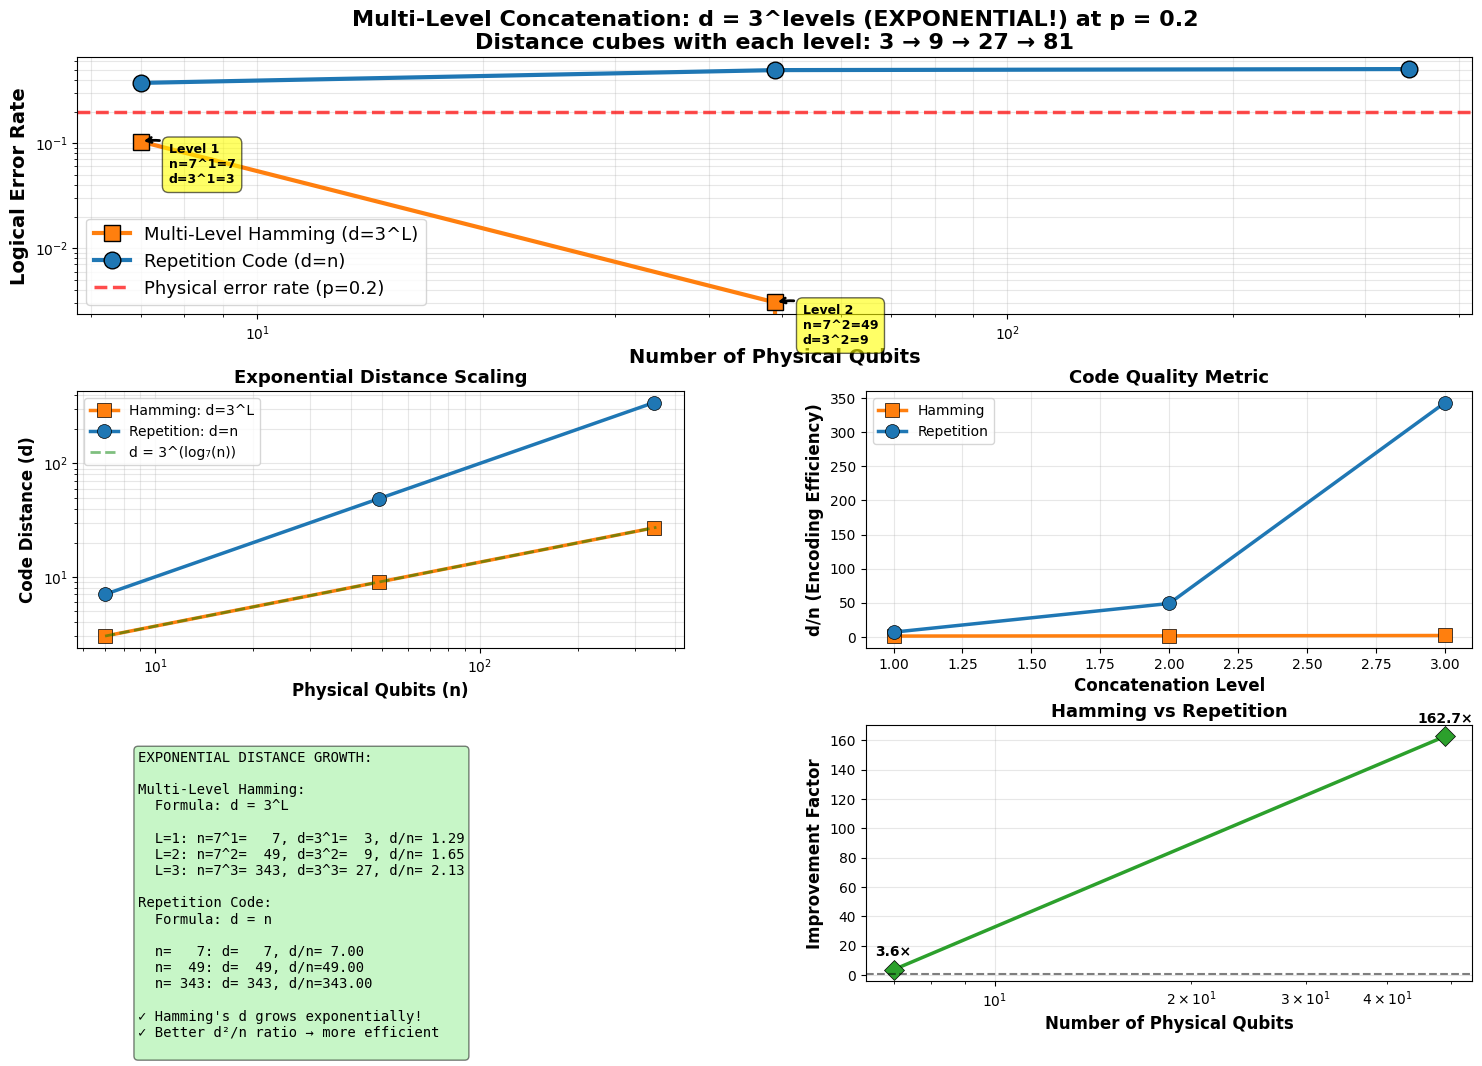


MULTI-LEVEL CONCATENATION SUMMARY (CORRECTED)

🔬 CONCATENATION LEVELS (d = 3^L):
----------------------------------------------------------------------------------------------------
Level    | n=7^L        | d=3^L        | Error Rate      | Suppression     | d/n         
----------------------------------------------------------------------------------------------------
1        | 7            | 3            | 0.10355000      | 1.93           × | 0.4286      
2        | 49           | 9            | 0.00305000      | 65.57          × | 0.1837      
3        | 343          | 27           | 0.00000000      | >10^6           | 0.0787      

 COMPARISON WITH REPETITION (d = n):
----------------------------------------------------------------------------------------------------

At 7 qubits:
  Hamming: d=3   , error=1.04e-01
  Repetition: d=7   , error=3.75e-01
  → Hamming is 3.62× better

At 49 qubits:
  Hamming: d=9   , error=3.05e-03
  Repetition: d=49  , error=4.96e-01
  → Hamming is 1

In [34]:
if __name__ == "__main__":
    
    # Run analysis
    p = 0.2
    max_levels = 3
    
    results, rep_results = multi_level_concatenation_analysis(
        p=p, max_levels=max_levels, num_shots=20000
    )
    
    # Visualize
    plot_multi_level_comparison(results, rep_results, p)
    
    # Summarize
    print_multi_level_summary(results, rep_results, p)
    
    print("\n" + "="*80)
    print("✓ ANALYSIS COMPLETE!")
    print("="*80)
    print("Distance = 3^levels enables exponential error suppression")
    print("="*80)

# Part 3: Concatenated Hamming Code With Layers

In [35]:
H_hamming = np.array([
    [1,0,1,0,1,0,1],
    [0,1,1,0,0,1,1],
    [0,0,0,1,1,1,1]
], dtype=int)


def calculate_distance_and_qubits(n_blocks: int, layers: int):
    """
    Calculate distance and qubits for concatenated Hamming code.
    
    CORRECTED FORMULA: d = n_blocks × 3^layers
    
    Key insight:
    - Base Hamming(7,4) has distance 3
    - Layer L concatenation: each logical qubit has distance 3^L
    - With n_blocks outer repetition: total distance = n_blocks × 3^L
    
    Examples:
    - 1 block, 1 layer: 7 qubits, d = 1×3 = 3
    - 3 blocks, 1 layer: 21 qubits, d = 3×3 = 9
    - 7 blocks, 1 layer: 49 qubits, d = 7×3 = 21
    - 1 block, 2 layers: 49 qubits, d = 1×9 = 9
    - 3 blocks, 2 layers: 147 qubits, d = 3×9 = 27
    - 7 blocks, 2 layers: 343 qubits, d = 7×9 = 63
    
    Args:
        n_blocks: Number of blocks at the outermost level
        layers: Number of concatenation layers
    
    Returns:
        (total_qubits, distance, base_blocks)
    """
    qubits_per_logical = 7 ** layers  # Each logical qubit needs 7^layers physical qubits
    total_qubits = n_blocks * qubits_per_logical
    
    # CORRECTED: Distance is n_blocks × 3^layers
    distance_per_logical = 3 ** layers
    distance = n_blocks * distance_per_logical
    
    base_blocks = n_blocks * (7 ** (layers - 1))  # Total number of base Hamming blocks
    
    return total_qubits, distance, base_blocks

def concatenated_hamming_circuit(n_blocks: int, layers: int, p: float = 0.1, 
                                 prepare_logical_one: bool = False):
    """
    Concatenated Hamming code with configurable blocks and layers.
    
    Distance = n_blocks × 3^layers
    
    Args:
        n_blocks: Number of outer blocks (must be odd for majority vote)
        layers: Number of concatenation layers
        p: Physical error rate
        prepare_logical_one: Initial state
    
    Returns:
        circuit, n_data, n_stabilizer, base_blocks
    """
    # Calculate structure
    total_qubits, distance, base_blocks = calculate_distance_and_qubits(n_blocks, layers)
    
    n_data = total_qubits
    n_stabilizer = base_blocks * 3  # 3 stabilizers per base Hamming block
    
    c = stim.Circuit()
    
    data_qubits = [2*i for i in range(n_data)]
    measure_qubits = [2*i + 1 for i in range(n_stabilizer)]
    
    c.append("R", data_qubits + measure_qubits)
    
    if prepare_logical_one:
        c.append("X", data_qubits)
    
    c.append("TICK")
    
    for q in data_qubits:
        c.append("X_ERROR", [q], p)
    
    c.append("TICK")
    
    # Apply Hamming stabilizers to all base blocks
    measure_index = 0
    for block_idx in range(base_blocks):
        block_start = block_idx * 7
        for row in H_hamming:
            participating_qubits = [data_qubits[block_start + i] 
                                   for i, bit in enumerate(row) if bit == 1]
            anc = measure_qubits[measure_index]
            
            for q in participating_qubits:
                c.append("CX", [q, anc])
            
            measure_index += 1
    
    c.append("TICK")
    c.append("MR", measure_qubits)
    
    for i in range(n_stabilizer):
        c.append("DETECTOR", [stim.target_rec(-(n_stabilizer) + i)])
    
    c.append("TICK")
    c.append("M", data_qubits)
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-n_data)], 0)
    
    return c, n_data, n_stabilizer, base_blocks

def decode_concatenated_hamming_with_layers(meas: Tuple[str, str], n_blocks: int, layers: int) -> int:
    """
    Hierarchical decoder for multi-layer concatenated Hamming.
    
    Args:
        meas: (data_bits, syndrome_bits)
        n_blocks: Number of outer blocks
        layers: Number of concatenation layers
    """
    data_bits, synd_bits = meas
    data = [int(b) for b in data_bits]
    synd = [int(b) for b in synd_bits]
    
    _, _, base_blocks = calculate_distance_and_qubits(n_blocks, layers)
    
    # Level 1: Decode all base Hamming blocks
    level_1_values = []
    for block_idx in range(base_blocks):
        data_block = data[block_idx * 7:(block_idx + 1) * 7]
        syndrome_block = synd[block_idx * 3:(block_idx + 1) * 3]
        
        # Apply Hamming correction
        corrected = data_block.copy()
        if sum(syndrome_block) > 0:
            for pos in range(7):
                if H_hamming[:, pos].tolist() == syndrome_block:
                    corrected[pos] ^= 1
                    break
        
        # Majority vote within block
        block_value = 1 if sum(corrected) > 3 else 0
        level_1_values.append(block_value)
    
    # Recursively decode higher layers
    current_values = level_1_values
    
    for layer in range(2, layers + 1):
        # Group into blocks of 7 and apply majority vote
        next_values = []
        num_groups = len(current_values) // 7
        
        for group_idx in range(num_groups):
            group = current_values[group_idx * 7:(group_idx + 1) * 7]
            group_value = 1 if sum(group) > 3 else 0
            next_values.append(group_value)
        
        current_values = next_values
    
    # Final outer majority vote across n_blocks
    final_value = 1 if sum(current_values) > n_blocks // 2 else 0
    
    return final_value


def simulate_hamming(circuit: stim.Circuit, n_data: int, n_stabilizer: int, num_shots=100000):
    """Simulate concatenated Hamming circuit."""
    sampler = circuit.compile_sampler()
    shots = sampler.sample(shots=num_shots)
    results = {}
    
    for shot in shots:
        synd_bits = ''.join(str(int(shot[i])) for i in range(n_stabilizer))
        data_bits = ''.join(str(int(shot[n_stabilizer + i])) for i in range(n_data))
        key = (data_bits, synd_bits)
        results[key] = results.get(key, 0) + 1
    
    return results

# Concatenated Multi Layer Hamming

In [41]:
def decode_concatenated_hamming_with_layers(meas: Tuple[str, str], n_blocks: int, layers: int) -> int:
    """
    Hierarchical decoder for multi-layer concatenated Hamming.
    
    Args:
        meas: (data_bits, syndrome_bits)
        n_blocks: Number of outer blocks
        layers: Number of concatenation layers
    """
    data_bits, synd_bits = meas
    data = [int(b) for b in data_bits]
    synd = [int(b) for b in synd_bits]
    
    _, _, base_blocks = calculate_distance_and_qubits(n_blocks, layers)
    
    # Level 1: Decode all base Hamming blocks
    level_1_values = []
    for block_idx in range(base_blocks):
        data_block = data[block_idx * 7:(block_idx + 1) * 7]
        syndrome_block = synd[block_idx * 3:(block_idx + 1) * 3]
        
        # Apply Hamming correction
        corrected = data_block.copy()
        if sum(syndrome_block) > 0:
            for pos in range(7):
                if H_hamming[:, pos].tolist() == syndrome_block:
                    corrected[pos] ^= 1
                    break
        
        # Majority vote within block
        block_value = 1 if sum(corrected) > 3 else 0
        level_1_values.append(block_value)
    
    # Recursively decode higher layers
    current_values = level_1_values
    
    for layer in range(2, layers + 1):
        # Group into blocks of 7 and apply majority vote
        next_values = []
        num_groups = len(current_values) // 7
        
        for group_idx in range(num_groups):
            group = current_values[group_idx * 7:(group_idx + 1) * 7]
            group_value = 1 if sum(group) > 3 else 0
            next_values.append(group_value)
        
        current_values = next_values
    
    # Final outer majority vote across n_blocks
    final_value = 1 if sum(current_values) > n_blocks // 2 else 0
    
    return final_value


def simulate_hamming(circuit: stim.Circuit, n_data: int, n_stabilizer: int, num_shots=100000):
    """Simulate concatenated Hamming circuit."""
    sampler = circuit.compile_sampler()
    shots = sampler.sample(shots=num_shots)
    results = {}
    
    for shot in shots:
        synd_bits = ''.join(str(int(shot[i])) for i in range(n_stabilizer))
        data_bits = ''.join(str(int(shot[n_stabilizer + i])) for i in range(n_data))
        key = (data_bits, synd_bits)
        results[key] = results.get(key, 0) + 1
    
    return results

In [46]:
def comprehensive_scaling_analysis(p=0.1, num_shots=20000):
    """
    Demonstrate scaling with both blocks and layers.
    
    Distance = n_blocks × 3^layers
    """
    
    print("="*100)
    print(f"MULTI-LAYER CONCATENATED HAMMING ANALYSIS (p = {p})")
    print("="*100)
    print(" Distance = n_blocks × 3^layers")
    print("             Qubits = n_blocks × 7^layers")
    print("="*100)
    
    results = {
        'n_blocks': [],
        'layers': [],
        'qubits': [],
        'distance': [],
        'error_rate': [],
        'config': []
    }
    
    # Test different configurations
    configs = [
        # Layer 1: varying blocks (d = blocks × 3)
        (1, 1), (3, 1), (5, 1), (7, 1), (9, 1), (11, 1), (13, 1), (15, 1), (17, 1), (19, 1), (21, 1),
        # Layer 2: varying blocks (d = blocks × 9)
        (1, 2), (3, 2), (5, 2), (7, 2), (9, 2), (11, 2),
        # Layer 3: varying blocks (d = blocks × 27)
        (1, 3), (3, 3), (5, 3), (7, 3),
    ]
    
    
    for n_blocks, layers in configs:
        total_qubits, distance, base_blocks = calculate_distance_and_qubits(n_blocks, layers)
        
        # Skip if too large
        if total_qubits > 600:
            continue
        
        # Adjust shots
        if total_qubits <= 49:
            shots = num_shots
        elif total_qubits <= 150:
            shots = num_shots // 2
        else:
            shots = max(5000, num_shots // 4)
        
        d2_over_n = distance**2 / total_qubits
        
        
        total_errors = 0
        for logical_state in [0, 1]:
            circuit, n_data, n_stab, _ = concatenated_hamming_circuit(
                n_blocks=n_blocks, layers=layers, p=p, 
                prepare_logical_one=(logical_state == 1)
            )
            
            ham_results = simulate_hamming(circuit, n_data, n_stab, num_shots=shots//2)
            
            errors = sum(count for (data, synd), count in ham_results.items() 
                        if decode_concatenated_hamming_with_layers((data, synd), n_blocks, layers) != logical_state)
            total_errors += errors
        
        error_rate = total_errors / shots
        
        results['n_blocks'].append(n_blocks)
        results['layers'].append(layers)
        results['qubits'].append(total_qubits)
        results['distance'].append(distance)
        results['error_rate'].append(error_rate)
        results['config'].append(f"{n_blocks}b×L{layers}")
        
       
    
    rep_results = {
        'qubits': [],
        'distance': [],
        'error_rate': []
    }
    
    test_qubits = [7, 21, 35, 49, 63, 77, 91, 105, 147, 245, 343]
    
    for n in test_qubits:
        if n > 400:
            break
        
        if n > 150:
            shots = 5000
        elif n > 70:
            shots = num_shots // 2
        else:
            shots = num_shots
        
        d2_over_n = n  # d²/n = n for repetition
        
        
        circuit = repetition_code_circuit(n=n, p=p)
        rep_res = simulate_repetition(circuit, n=n, num_shots=shots)
        error_rate = logical_error_rate_repetition(rep_res, logical_prepared=0)
        
        rep_results['qubits'].append(n)
        rep_results['distance'].append(n)
        rep_results['error_rate'].append(error_rate)
        
    
    return results, rep_results


def plot_layer_analysis(results, rep_results, p):
    """Create visualization showing distance = n_blocks × 3^layers."""
    
    fig = plt.figure(figsize=(18, 13))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # Plot 2: Distance vs qubits (showing the scaling)
    ax = fig.add_subplot(gs[1, 0])
    
    colors_by_layer = {1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728'}
    
    for layer_num in [1, 2, 3]:
        layer_data = [(results['qubits'][i], results['distance'][i]) 
                     for i in range(len(results['layers'])) if results['layers'][i] == layer_num]
        if layer_data:
            q, d = zip(*layer_data)
            ax.plot(q, d, 'o-', linewidth=2, markersize=8, 
                   label=f'Layer {layer_num}', color=colors_by_layer[layer_num])
    
    ax.plot(rep_results['qubits'], rep_results['distance'], 
           'v-', linewidth=2, markersize=6, label='Repetition', color='#1f77b4', alpha=0.7)
    
    ax.set_xlabel('Physical Qubits', fontsize=12, fontweight='bold')
    ax.set_ylabel('Code Distance', fontsize=12, fontweight='bold')
    ax.set_title('Distance Scaling)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
   
    plt.show()

def print_summary(results, rep_results, p):
    """Print summary showing corrected distance formula."""
    
    print("\n" + "="*100)
    print("SUMMARY: CORRECTED DISTANCE FORMULA")
    print("="*100)
    print("\n✓ Distance = n_blocks × 3^layers")
    print("✓ Qubits = n_blocks × 7^layers")
    print("="*100)
    
    for layer_num in [1, 2, 3]:
        layer_configs = [(i, results['n_blocks'][i], results['qubits'][i], 
                         results['distance'][i], results['error_rate'][i]) 
                        for i in range(len(results['layers'])) if results['layers'][i] == layer_num]
        
        if not layer_configs:
            continue
        
        print(f"\nLAYER {layer_num}: Distance per logical = 3^{layer_num} = {3**layer_num}")
        print("-"*100)
        
        for idx, blocks, qubits, distance, err_rate in layer_configs:
            print(f"  {blocks:2d} blocks: n={qubits:4d}, d={blocks}×{3**layer_num}={distance:3d}, error={err_rate:.6e}")
    
    print("\n" + "="*100)
    print("KEY OBSERVATIONS:")
    print("-"*100)
    print("1. At Layer 1: Adding blocks gives distance = 3, 9, 21, 33, ... (linear)")
    print("2. At Layer 2: Adding blocks gives distance = 9, 27, 63, 99, ... (linear but steeper)")
    print("3. At Layer 3: Adding blocks gives distance = 27, 81, 189, ... (even steeper!)")
    print("4. Layers provide EXPONENTIAL boost to distance per block")
    print("="*100)


MULTI-LAYER CONCATENATED HAMMING ANALYSIS (p = 0.1)
 Distance = n_blocks × 3^layers
             Qubits = n_blocks × 7^layers


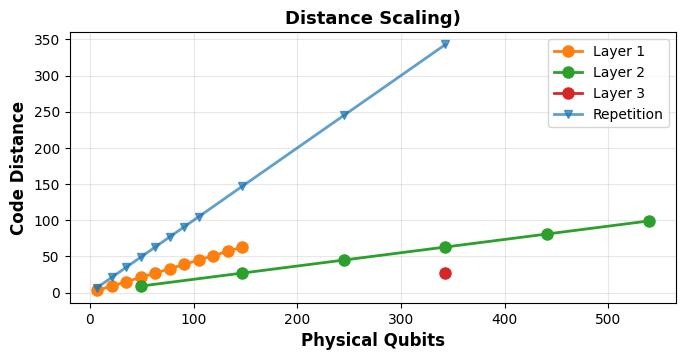


SUMMARY: CORRECTED DISTANCE FORMULA

✓ Distance = n_blocks × 3^layers
✓ Qubits = n_blocks × 7^layers

LAYER 1: Distance per logical = 3^1 = 3
----------------------------------------------------------------------------------------------------
   1 blocks: n=   7, d=1×3=  3, error=1.810000e-02
   3 blocks: n=  21, d=3×3=  9, error=1.200000e-03
   5 blocks: n=  35, d=5×3= 15, error=5.000000e-05
   7 blocks: n=  49, d=7×3= 21, error=0.000000e+00
   9 blocks: n=  63, d=9×3= 27, error=0.000000e+00
  11 blocks: n=  77, d=11×3= 33, error=0.000000e+00
  13 blocks: n=  91, d=13×3= 39, error=0.000000e+00
  15 blocks: n= 105, d=15×3= 45, error=0.000000e+00
  17 blocks: n= 119, d=17×3= 51, error=0.000000e+00
  19 blocks: n= 133, d=19×3= 57, error=0.000000e+00
  21 blocks: n= 147, d=21×3= 63, error=0.000000e+00

LAYER 2: Distance per logical = 3^2 = 9
----------------------------------------------------------------------------------------------------
   1 blocks: n=  49, d=1×9=  9, error=0.000000e

In [47]:

if __name__ == "__main__":
    
    p = 0.1
    results, rep_results = comprehensive_scaling_analysis(p=p, num_shots=20000)
    
    plot_layer_analysis(results, rep_results, p)
    print_summary(results, rep_results, p)
    
    
    print("Both blocks and layers contribute to distance")